# Finding Bayesian Legos

TODO: Story line about friend and child leaving legos on floor.  Need picture of legos in Bin and scattered on floor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

np.random.seed(42)  # It's nice to replicate even virtual experiments

In [2]:
import pymc3 as pm
import scipy.stats as stats
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


## Frequentists do it twenty times

Run an experiment, where there are an unknown number of legos left on the floor.

In [3]:
mean = 100
standard_deviation = 20
experiments = 20
N_0 = (np.random.randn(experiments)*standard_deviation+mean).astype(int)
N_0

array([109,  97, 112, 130,  95,  95, 131, 115,  90, 110,  90,  90, 104,
        61,  65,  88,  79, 106,  81,  71])

In [4]:
# TODO Run experiments
actual_prob = 0.7  # Friend is good at finding the legos, but doesn't know that
X_1 = np.random.binomial(N_0, actual_prob)  
X_1

array([76, 67, 83, 88, 59, 58, 85, 84, 64, 78, 71, 57, 73, 45, 45, 61, 59,
       66, 56, 44])

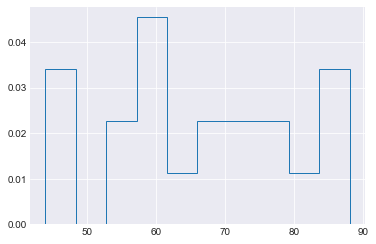

In [5]:
# For each trial, out of N(100,20) how many did my friend pickup
plt.hist(X_1, histtype='step', density=True);

In [6]:
alpha=2  # or 1.1
beta=2   # or 1.1

basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha, beta=beta)
    x_1 = pm.Binomial('x_1', n=N_0, p=p, observed=X_1)

In [7]:
with basic_model:
    trace = pm.sample(50000, random_seed=123, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:57<00:00, 1765.42draws/s]


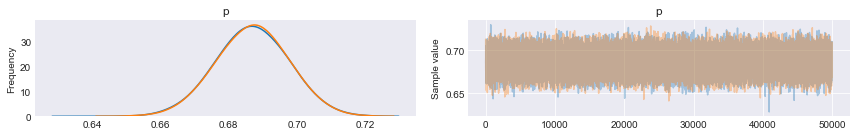

In [8]:
pm.traceplot(trace, varnames=['p']);

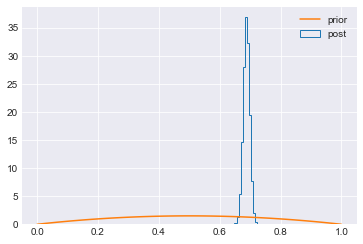

In [9]:
plt.hist(trace['p'], 15, histtype='step', density=True, label='post');
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, alpha, beta), label='prior');
plt.legend(loc='best');

In [10]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.69,0.01,0.0,0.67,0.71,40577.71,1.0


In [11]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(50000, step, random_seed=123, progressbar=True) 

Multiprocess sampling (2 chains in 2 jobs)
Slice: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:43<00:00, 2312.78draws/s]


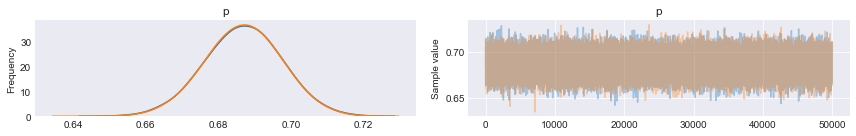

In [12]:
pm.traceplot(trace, varnames=['p']);  

In [13]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.69,0.01,0.0,0.67,0.71,98175.39,1.0


## Bayesians do it in passes - first pass

In [14]:
np.random.seed(42)
N_0 = int(np.random.randn()*standard_deviation+mean)
X_1 = np.random.binomial(N_0, actual_prob)
X_1

74

In [15]:
basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha, beta=beta)
    n_0 = pm.DiscreteUniform('n_0', lower=0, upper=3000)  # Lots of legos
    x_1 = pm.Binomial('x_1', n=n_0, p=p, observed=X_1)

In [16]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(50000, step, tune=5000, random_seed=123, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [n_0]
>Slice: [p]
Sampling 2 chains: 100%|██████████| 110000/110000 [01:25<00:00, 1285.18draws/s]
The number of effective samples is smaller than 10% for some parameters.


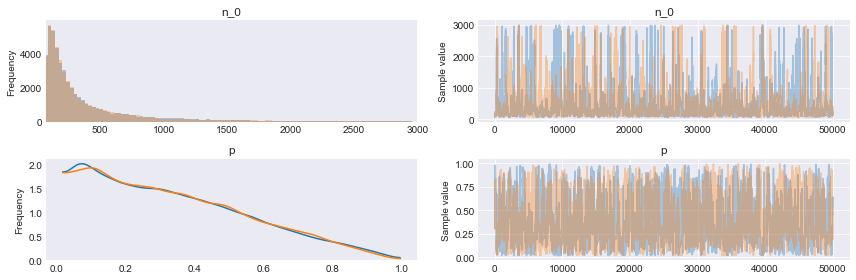

In [17]:
pm.traceplot(trace, varnames=['n_0', 'p']);

In [18]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0,434.74,493.86,16.20,74.00,1541.00,750.46,1.0
p,0.34,0.23,0.01,0.02,0.77,748.99,1.0


## Second pass

In [19]:
N_1 = N_0 - X_1       # Number remaining after first removal, only I know
X_2 = np.random.binomial(N_1, actual_prob)  # Second Removal
print('First removal = {}, Second removal = {}'.format(X_1, X_2))

First removal = 74, Second removal = 26


In [20]:
basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha, beta=beta)
    n_0 = pm.DiscreteUniform('n_0', lower=0, upper=3000)
    x_1 = pm.Binomial('x_1', n=n_0, p=p, observed=X_1)
    n_1 = n_0 - x_1
    x_2 = pm.Binomial('x_2', n=n_1, p=p, observed=X_2)

In [21]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(50000, step, tuning=5000, random_seed=123, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [n_0]
>Slice: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [01:26<00:00, 1164.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


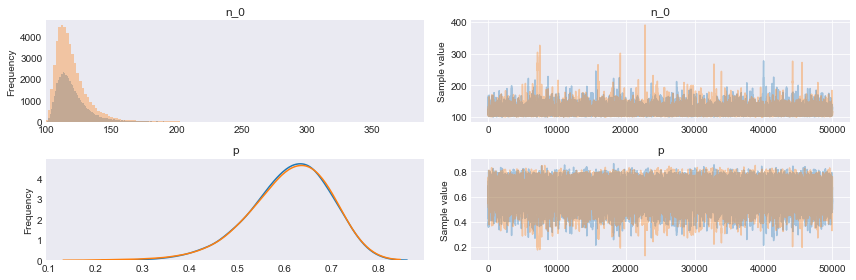

In [22]:
pm.traceplot(trace, varnames=['n_0', 'p']);

In [23]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0,120.10,13.80,0.18,101.00,144.00,5755.86,1.0
p,0.61,0.09,0.00,0.44,0.77,7902.13,1.0


## Pass Three

In [24]:
N_2 = N_1 - X_2
X_3 = np.random.binomial(N_2, actual_prob) # Third Removal
print('First removal = {}, Second removal = {}, Third removal = {}'.format(X_1, X_2, X_3))

First removal = 74, Second removal = 26, Third removal = 7


In [25]:
basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha, beta=beta)
    n_0 = pm.DiscreteUniform('n_0', lower=0, upper=3000) # Loosen prior, was X_1+X_2+X_3
    x_1 = pm.Binomial('x_1', n=n_0, p=p, observed=X_1)
    n_1 = n_0 - x_1
    x_2 = pm.Binomial('x_2', n=n_1, p=p, observed=X_2)
    n_2 = n_1 - x_2
    x_3 = pm.Binomial('x_3', n=n_2, p=p, observed=X_3)

In [26]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(50000, step, tuning=5000, random_seed=123, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [n_0]
>Slice: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [01:44<00:00, 968.01draws/s]


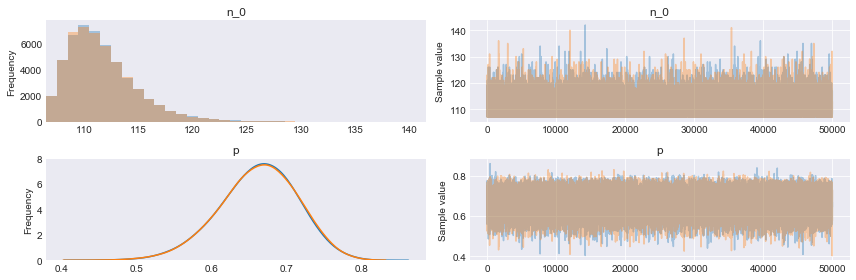

In [27]:
pm.traceplot(trace, varnames=['n_0', 'p']);

In [28]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0,111.68,3.24,0.02,107.00,118.00,27115.53,1.0
p,0.66,0.05,0.00,0.56,0.76,30378.19,1.0


In [29]:
N_3 = N_2 - X_3
X_4 = np.random.binomial(N_3, actual_prob)
N_4 = N_3 - X_4
X_5 = np.random.binomial(N_4, actual_prob)
print(f'{X_1} {X_2} {X_3} {X_4} {X_5}')

74 26 7 2 0


In [30]:
basic_model = pm.Model()

with basic_model:
    p = pm.Beta('p', alpha=alpha, beta=beta)
    n_0 = pm.DiscreteUniform('n_0', lower=0, upper=3000) # Loosen prior, was X_1+X_2+X_3
    x_1 = pm.Binomial('x_1', n=n_0, p=p, observed=X_1)
    n_1 = n_0 - x_1
    x_2 = pm.Binomial('x_2', n=n_1, p=p, observed=X_2)
    n_2 = n_1 - x_2
    x_3 = pm.Binomial('x_3', n=n_2, p=p, observed=X_3)
    n_3 = n_2 - x_3
    x_4 = pm.Binomial('x_4', n=n_3, p=p, observed=X_4)
    n_4 = n_3 - x_4
    x_5 = pm.Binomial('x_5', n=n_4, p=p, observed=X_5)
    

In [31]:
with basic_model:
    step = pm.Slice()
    trace = pm.sample(50000, step, tuning=5000, random_seed=123, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [n_0]
>Slice: [p]
Sampling 2 chains: 100%|██████████| 101000/101000 [01:44<00:00, 963.34draws/s]


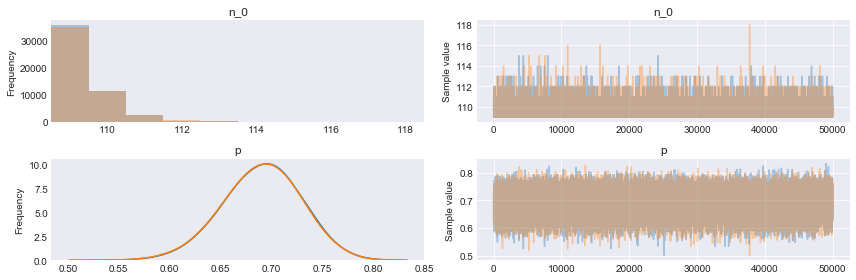

In [32]:
pm.traceplot(trace, varnames=['n_0', 'p']);

In [33]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
n_0,109.36,0.65,0.0,109.00,111.00,37352.63,1.0
p,0.69,0.04,0.0,0.61,0.76,71064.70,1.0


In [34]:
N_0

109